In [3]:
%pip install opendatasets --quiet
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/mssmartypants/rice-type-classification'

od.download(dataset_url)


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle username:Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|██████████| 888k/888k [00:00<00:00, 674MB/s]

In [6]:
%pip install torchsummary --quiet


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


device = 'mps' if torch.backends.mps.is_available() else 'cpu'


In [14]:
data_df = pd.read_csv('rice-type-classification/riceClassification.csv')

print(data_df.head())

   id  Area  MajorAxisLength  ...  Roundness  AspectRation  Class
0   1  4537        92.229316  ...   0.764510      1.440796      1
1   2  2872        74.691881  ...   0.831658      1.453137      1
2   3  3048        76.293164  ...   0.868434      1.465950      1
3   4  3073        77.033628  ...   0.870203      1.483456      1
4   5  3693        85.124785  ...   0.874743      1.510000      1

[5 rows x 12 columns]


In [15]:
data_df.dropna(inplace=True)
data_df.drop(['id'],axis=1 , inplace=True)
print(data_df.shape)

(18185, 11)


In [16]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [20]:
print(data_df['Class'].value_counts())

Class
1    9985
0    8200
Name: count, dtype: int64


In [24]:
original_df = data_df.copy()

for column in data_df.columns:
  data_df[column]=data_df[column]/data_df[column].abs().max()

data_df.head()


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [26]:
X = np.array(data_df.iloc[:,:-1])
Y = np.array(data_df.iloc[:,-1])

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3)

In [33]:
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size=0.5)

In [34]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(12729, 10)
(2728, 10)
(2728, 10)


In [42]:
class dataset(Dataset):
  def __init__(self, X, Y):
    self.X=torch.tensor(X, dtype=torch.float32).to(device)
    self.Y=torch.tensor(Y, dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.X)
  
  def __getitem__(self, index):
    return self.X[index], self.Y[index]

In [43]:
training_data = dataset(X_train, y_train)
validation_data = dataset(X_val,y_val)
testing_data = dataset(X_test,y_test)

In [44]:
train_dataloader= DataLoader(training_data, batch_size=8, shuffle=True)
val_dataloader= DataLoader(validation_data, batch_size=8, shuffle=True)
testing_dataloader= DataLoader(testing_data, batch_size=8, shuffle=True)

In [53]:
# Input → 64 neurons → 1 output → squash to (0,1)

HIDDEN_NEURONS=64

class MyModel(nn.Module):
  def __init__(self):
    super(MyModel,self).__init__()

    self.input_layer=nn.Linear(X.shape[1], HIDDEN_NEURONS)
    self.linear = nn.Linear(HIDDEN_NEURONS,1)
    self.sigmoid = nn.Sigmoid()


  def forward(self,x):
    x=self.input_layer(x)
    x=self.linear(x)
    x=self.sigmoid(x)
    return x
  
model=MyModel().to(device)

In [59]:
model = model.to('cpu')

summary(model, (X.shape[1],), device='cpu')

model=model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 64]             704
            Linear-2                    [-1, 1]              65
           Sigmoid-3                    [-1, 1]               0
Total params: 769
Trainable params: 769
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [60]:
criterion= nn.BCELoss()
optimizer=Adam(model.parameters(), lr=1e-4)

In [83]:
total_loss_train_plot= []
total_loss_validation_plot =[] 
total_acc_train_plot=[]
total_acc_validation_plot=[]

epochs=10

for epoch in range(epochs):
  total_acc_train=0
  total_loss_train= 0
  total_acc_val=0 
  total_loss_val=0

  for data in train_dataloader:
    inputs, labels=data
    prediction=model(inputs).squeeze(1)
    #print(prediction.shape)
    #print(prediction.squeeze(1).shape)

    batch_loss=criterion(prediction,labels)

    total_loss_train += batch_loss.item()

    acc = ((prediction.round())==labels).sum().item()

    total_acc_train += acc

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    for data in val_dataloader:
      inputs,labels= data

      prediction=model(inputs).squeeze(1)
      batch_loss=criterion(prediction, labels)

      total_loss_val+= batch_loss.item()
      acc = ((prediction.round())==labels).sum().item()

      total_acc_val+=acc

  
  total_loss_train_plot.append(round(total_loss_train/1000,4))
  total_loss_validation_plot.append(round(total_loss_val/1000,4))

  total_acc_train_plot.append(round(total_acc_train/training_data.__len__()*100,4))
  total_acc_validation_plot.append(round(total_acc_val/validation_data.__len__()*100,4))

  print(f'''Epoch no. {epoch+1} Train Loss: {round(total_loss_train/1000,4)} Train Accuracy {round(total_acc_train/training_data.__len__()*100,4)}
  Validation loss: {round(total_loss_train/1000,4)} Validation Accuracy: {round(total_acc_val/validation_data.__len__()*100,4)}''')

  print("="*25)

Epoch no. 1 Train Loss: 0.0749 Train Accuracy 98.6566
  Validation loss: 0.0749 Validation Accuracy: 98.7537
Epoch no. 2 Train Loss: 0.0728 Train Accuracy 98.688
  Validation loss: 0.0728 Validation Accuracy: 98.717
Epoch no. 3 Train Loss: 0.0718 Train Accuracy 98.6488
  Validation loss: 0.0718 Validation Accuracy: 98.6437
Epoch no. 4 Train Loss: 0.0698 Train Accuracy 98.6409
  Validation loss: 0.0698 Validation Accuracy: 98.717
Epoch no. 5 Train Loss: 0.0689 Train Accuracy 98.6016
  Validation loss: 0.0689 Validation Accuracy: 98.717
Epoch no. 6 Train Loss: 0.0682 Train Accuracy 98.6802
  Validation loss: 0.0682 Validation Accuracy: 98.7537
Epoch no. 7 Train Loss: 0.0672 Train Accuracy 98.633
  Validation loss: 0.0672 Validation Accuracy: 98.607
Epoch no. 8 Train Loss: 0.0668 Train Accuracy 98.6488
  Validation loss: 0.0668 Validation Accuracy: 98.6437
Epoch no. 9 Train Loss: 0.0662 Train Accuracy 98.6723
  Validation loss: 0.0662 Validation Accuracy: 98.607
Epoch no. 10 Train Loss: 0

In [73]:
with torch.no_grad():
  total_loss_test = 0 
  total_acc_test  = 0

  for data in testing_dataloader:
    inputs, labels =data 

    prediction=model(inputs).squeeze(1)
    batch_loss_test= criterion(prediction, labels).item()
    total_loss_test+=batch_loss_test

    acc = ((prediction.round())==labels).sum().item()

    total_acc_test+=acc


print("Accuracy: ", round(total_acc_test/testing_data.__len__()*100,4))
    

Accuracy:  98.5704


[0.0749, 0.0728, 0.0718, 0.0698, 0.0689, 0.0682, 0.0672, 0.0668, 0.0662, 0.0657]
[0.0149, 0.0145, 0.0144, 0.014, 0.0139, 0.0137, 0.0137, 0.0137, 0.0136, 0.0136]


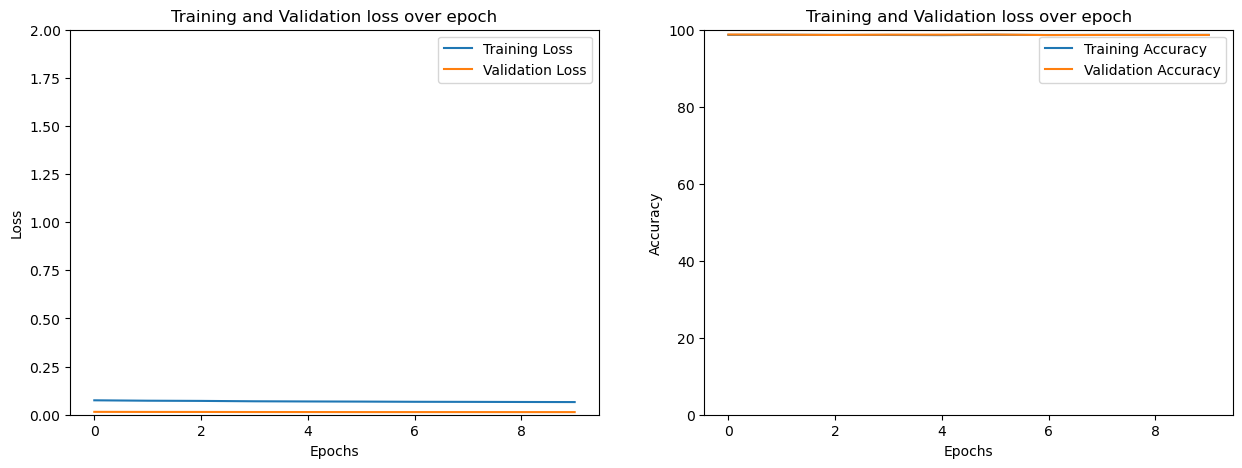

In [84]:
print(total_loss_train_plot)
print(total_loss_validation_plot)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title("Training and Validation loss over epoch")
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0,2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title("Training and Validation loss over epoch")
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0,100])
axs[1].legend()

plt.show()


In [85]:
original_df

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1
...,...,...,...,...,...,...,...,...,...,...,...
18180,5853,148.624571,51.029281,0.939210,6008,86.326537,0.498594,332.960,0.663444,2.912535,0
18181,7585,169.593996,58.141659,0.939398,7806,98.272692,0.647461,385.506,0.641362,2.916910,0
18182,6365,154.777085,52.908085,0.939760,6531,90.023162,0.561287,342.253,0.682832,2.925396,0
18183,5960,151.397924,51.474600,0.940427,6189,87.112041,0.492399,343.371,0.635227,2.941216,0


In [90]:
Area =  2353/original_df['Area'].abs().max()
MajorAxisLength = 81/original_df['MajorAxisLength'].abs().max()
MinorAxisLength = 42/original_df['MinorAxisLength'].abs().max()
Eccentricity = 32/original_df['Eccentricity'].abs().max()
ConvexArea = 12/original_df['ConvexArea'].abs().max()
EquivDiameter = 33/original_df['EquivDiameter'].abs().max()
Extent = 98/original_df['Extent'].abs().max()
Perimeter = 927/original_df['Perimeter'].abs().max()
Roundness = 677/original_df['Roundness'].abs().max()
AspectRation = 24/original_df['AspectRation'].abs().max()

my_prediction=model(torch.tensor([Area,MajorAxisLength,MinorAxisLength, Eccentricity, ConvexArea, EquivDiameter, Extent, Perimeter, Roundness, AspectRation], dtype=torch.float32).to(device))

In [94]:
round(my_prediction.item())

0